In [1]:
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

import cv2
import numpy as np
from utils import show_images

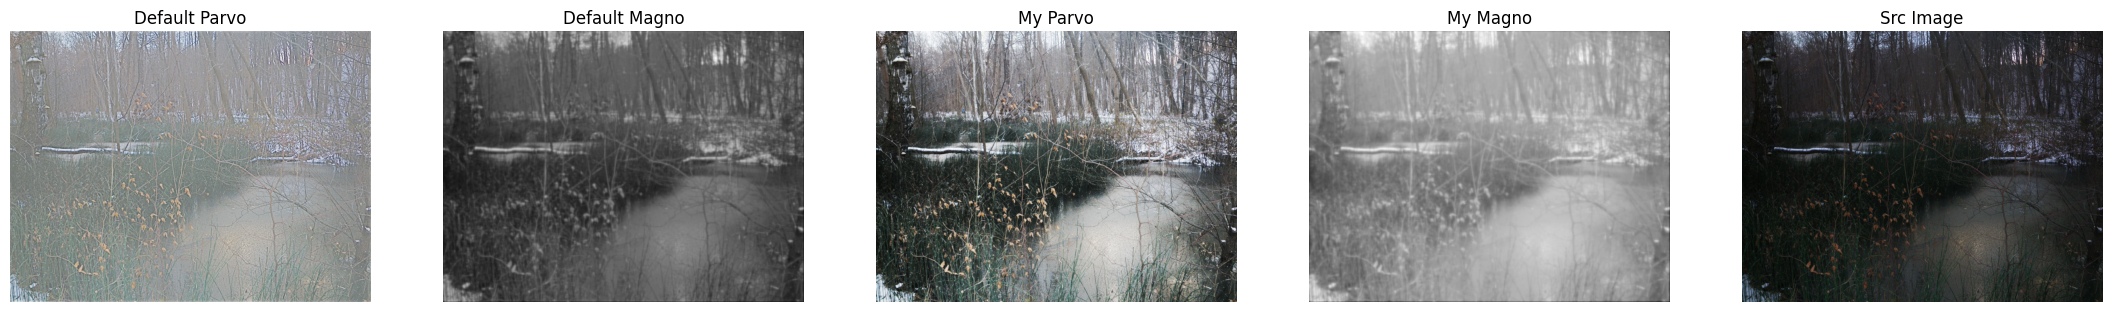

In [18]:
'''
Retina 可以提高对比度
'''
result = []

# 说明：在 retina 处理 src 前可以进一步处理 src，常见的如只保留直方图的 5%-95% 之间的像素
src = cv2.imread('./image/retina/input.JPG')

# 创建 retina
retina = cv2.bioinspired_Retina.create((src.shape[1], src.shape[0]))
 
# 打印属性 / 保存属性
# retina.write('retinaParams.xml')
# print(retina.printSetup())

# 读取默认配置
retina.setup('./data/retina/default_retina_config.xml')
retina.run(src)
result.append(('Default Parvo', retina.getParvo()))
result.append(('Default Magno', retina.getMagno()))

# 各个参数含义：https://docs.opencv.org/4.x/d2/d94/bioinspired_retina.html
retina.setColorSaturation(colorSaturationValue=4.0)
# 重要：参数必须要一下子设完，不要出现多次 setupxxx，否则当前 setup 会用默认值覆盖掉前面设好的参数！
retina_config = {
    'photoreceptorsLocalAdaptationSensitivity': 0.6, 
    'ganglionCellsSensitivity': 0.6, 
    'horizontalCellsGain': 20,
}
retina.setupOPLandIPLParvoChannel(**retina_config)
# 可以用 write 到一个配置文件中，看看是否参数设置成功
# retina.write('./test.xml') 
retina.run(src)
result.append(('My Parvo', retina.getParvo()))
result.append(('My Magno', retina.getMagno()))

## 实际上是通过如下对比方式来确定参数的
# for i in range(10):
#     retina.setupOPLandIPLParvoChannel(horizontalCellsGain=i/10)
#     retina.run(src)
#     result.append((f'{i/10}', retina.getParvo()))
#     result.append((f'{i/10}', retina.getMagno()))

result.append(('Src Image', src))
show_images(result, colnum=5, scale=4)

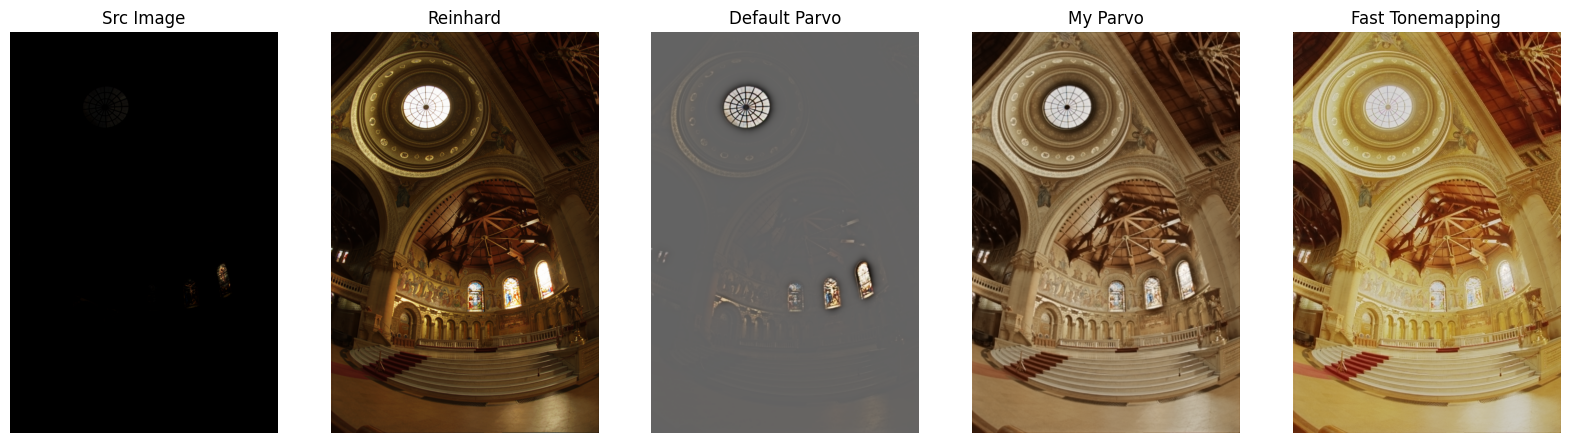

In [2]:
'''
使用 Retina 解决 ToneMapping，主要利用 getParvo
'''
result = []

# import cv2 前有一个关于 OpenEXR 的设置，这样才能用 cv2 读取 EXR 文件
# 说明：在 retina 处理 src 前可以进一步处理 src，常见的如只保留直方图的 5%-95% 之间的像素
src = cv2.imread('./image/retina/memorial.exr', -1)
src = (src / src.max()) * 255
result.append(('Src Image', src.astype(np.uint8)))

tonemapReinhard = cv2.createTonemapReinhard(1.5,0,0,0)
ldrReinhard = tonemapReinhard.process(src)
ldrReinhard[np.isnan(ldrReinhard)] = 0
ldrReinhard = (ldrReinhard * 255).clip(0, 255).astype('uint8')
result.append(('Reinhard', ldrReinhard))

retina = cv2.bioinspired_Retina.create((src.shape[1], src.shape[0]))
retina.run(src)
result.append(('Default Parvo', retina.getParvo()))

# 重要：参数必须要一下子设完，不要出现多次 setupxxx，否则当前 setup 会用默认值覆盖掉前面设好的参数！
retina_config = {
    'photoreceptorsLocalAdaptationSensitivity': 0.99, 
    'ganglionCellsSensitivity': 0.95, 
    'horizontalCellsGain': 40,
}
retina.setupOPLandIPLParvoChannel(**retina_config)
# 重要：可以通过 write 函数检查是否生效
# retina.write('./test.xml')
retina.run(src)
result.append(('My Parvo', retina.getParvo()))

# 专门的 applyTonemapping，考虑的参数更少，更快一点，来自一篇论文。见 RetinaFastToneMapping 的 Opencv 官方文档。
result.append(('Fast Tonemapping', retina.applyFastToneMapping(src)))

# # 使用自带的 Retina ToneMapping，但不知道为什么默认参数下出来的是黑色图片
# model = cv2.bioinspired.RetinaFastToneMapping.create((src.shape[1], src.shape[0]))
# result.append(('Fast ToneMapping', model.applyFastToneMapping(src)))

show_images(result, colnum=5)

# 其他说明
# 1. 实际使用推荐各个参数仔细调节，如 OpenCV 给的 sample 代码一样，可以每个参数用一个拉拽的条便于调节
# 2. 专门的 RetinaToneMapping Class，目的是相对而言更省空间（见 OpenCV 文档），但如上面代码所说，不知道为啥出来是黑色图片

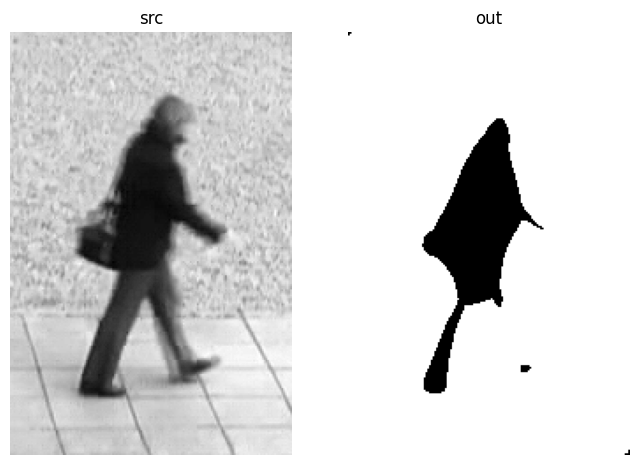

In [3]:
'''
使用 Retina 解决 运动检测，主要利用 getMagno
'''
src = cv2.imread('./image/retina/inputBag.jpg')
src = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

model = cv2.bioinspired.TransientAreasSegmentationModule.create((src.shape[1], src.shape[0]))

# 使用默认参数
model.setup()
model.run(src)

out = model.getSegmentationPicture()
out[out == 1] = 255

show_images([
    ('src', src),
    ('out', out)
])